In [1]:
import skimage.exposure as exposure 
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import dxchange
import logging
import tomopy
import os 

logging.basicConfig(level=logging.INFO)

### Load data from h5 file

In [2]:
os.environ["TOMOPY_PYTHON_THREADS"]="4"  

proj, flat, dark, theta = dxchange.read_aps_32id(
    fname='data.h5',
    sino=(511,512),  # Select the sinogram range to reconstruct.
)

INFO:dxchange.reader:Data successfully imported: D:\IPGG\Argonne\TomoPy_OpenPNM\data.h5
INFO:dxchange.reader:Data successfully imported: D:\IPGG\Argonne\TomoPy_OpenPNM\data.h5
INFO:dxchange.reader:Data successfully imported: D:\IPGG\Argonne\TomoPy_OpenPNM\data.h5
INFO:dxchange.reader:Data successfully imported: D:\IPGG\Argonne\TomoPy_OpenPNM\data.h5


### Make data pre-preprocessing 

In [3]:
# normalization
proj = tomopy.normalize(proj, flat, dark)
# linearization 
proj = tomopy.minus_log(proj)
# remove inf 
proj[np.where(proj == np.inf)] = 0
# remove nan 
proj = tomopy.misc.corr.remove_nan(proj)
# remove negative values 
proj = tomopy.misc.corr.remove_neg(proj)
# stripe removal 
proj = tomopy.prep.stripe.remove_all_stripe(proj, snr=3, la_size=61, sm_size=21, 
                                            ncore=None, nchunk=None)
# phase retrival
proj = tomopy.prep.phase.retrieve_phase(proj, pixel_size=3.45*1e-4, dist=100,
                                        energy=20, alpha=0.005, pad=True, ncore=None, 
                                        nchunk=None)

###  Plot a projection 

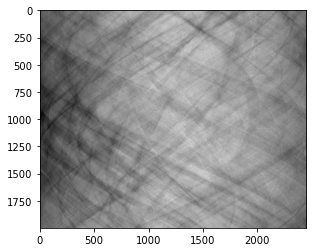

In [4]:
plt.imshow(proj[:,0,:],cmap = 'gray')

### Reconstruction

In [5]:
recon = tomopy.recon(proj, theta, center=1250, algorithm='gridrec', sinogram_order=False)
recon = recon - recon.min()
recon = recon/recon.max()

print(recon.min(),recon.max())

Reconstructing 1 slice groups with 1 master threads...
0.0 1.0


### Contrast stretching

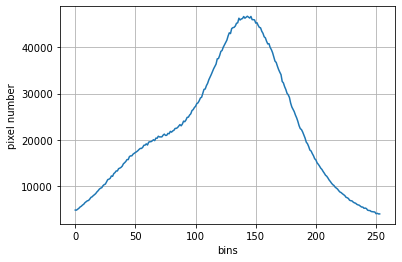

In [6]:
for j in range(recon.shape[0]):
    p2, p98 = np.percentile(recon[0,:,:], (2, 95))
    recon[0,:,:] = exposure.rescale_intensity(recon[0,:,:], in_range=(p2, p98))
    
hist = cv.calcHist([recon[0,:,:]*255],[0],None,[256],[0,256])

fig, ax = plt.subplots()

ax.plot(hist[1:255,0])
ax.grid()

ax.set_xlabel('bins')
ax.set_ylabel('pixel number')

plt.show()

### Apply mask and plot reconsructed image

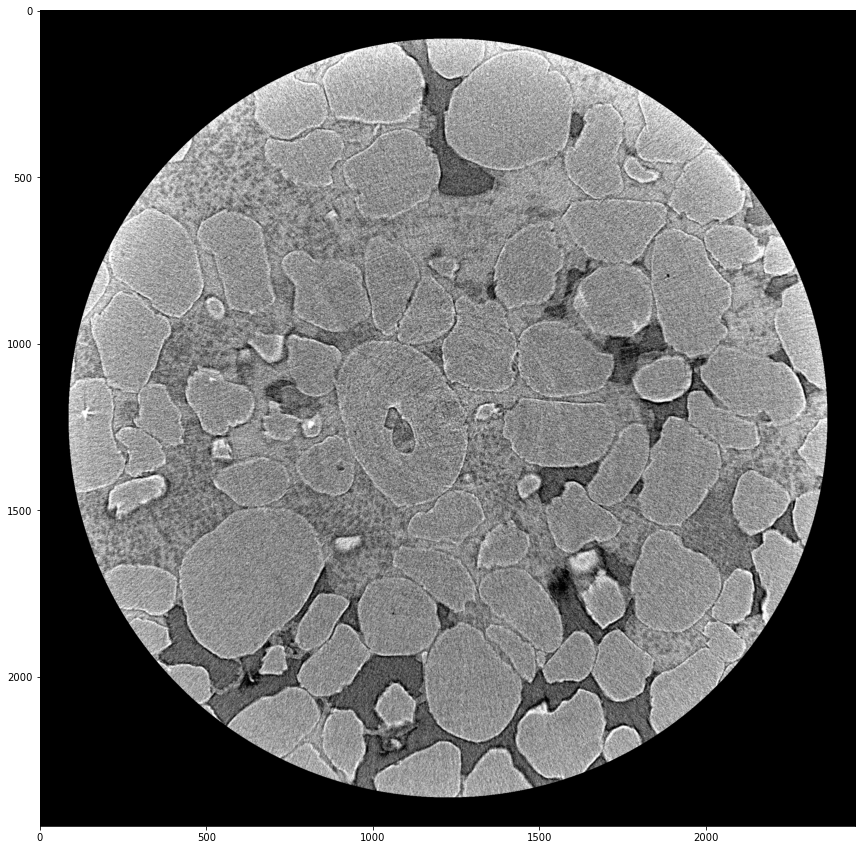

In [7]:
recon = tomopy.misc.corr.circ_mask(recon, axis=0, ratio=0.93,val=0)
plt.figure(figsize = (15,15))
plt.imshow(recon[0,:,:] , cmap = 'gray')